#SEGMENTADOR

##1. Preparación de los datos.

In [ ]:

## CARGA DE DATOS
## ========================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/CXR_Masks.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13734072424136475915, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4074222911322179549
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## Importación de las librería necesarias
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, Model, load_model
from tensorflow.keras.layers    import Input, Add, Dense, Activation, Conv2DTranspose, concatenate, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import load_img

import os
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS Y PARÁMETROS
## =============================================================================

base_dir = 'drive/MyDrive/TFM/COVID-19_Radiography/'
input_dir = 'dataset/CXR/'
target_dir = 'dataset/masks/'
img_size = (224, 224)
num_classes = 1
batch_size = 32

In [ ]:
## DIRECTORIO PARA CADA IMAGEN
## =============================================================================

input_img_paths =  sorted(list(map(lambda image: os.path.join(input_dir, image), os.listdir(input_dir))))
target_img_paths = sorted(list(map(lambda image: os.path.join(target_dir, image), os.listdir(target_dir))))

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 704
dataset/CXR/image_0.png | dataset/masks/image_0.png
dataset/CXR/image_1.png | dataset/masks/image_1.png
dataset/CXR/image_10.png | dataset/masks/image_10.png
dataset/CXR/image_100.png | dataset/masks/image_100.png
dataset/CXR/image_101.png | dataset/masks/image_101.png
dataset/CXR/image_102.png | dataset/masks/image_102.png
dataset/CXR/image_103.png | dataset/masks/image_103.png
dataset/CXR/image_104.png | dataset/masks/image_104.png
dataset/CXR/image_105.png | dataset/masks/image_105.png
dataset/CXR/image_106.png | dataset/masks/image_106.png


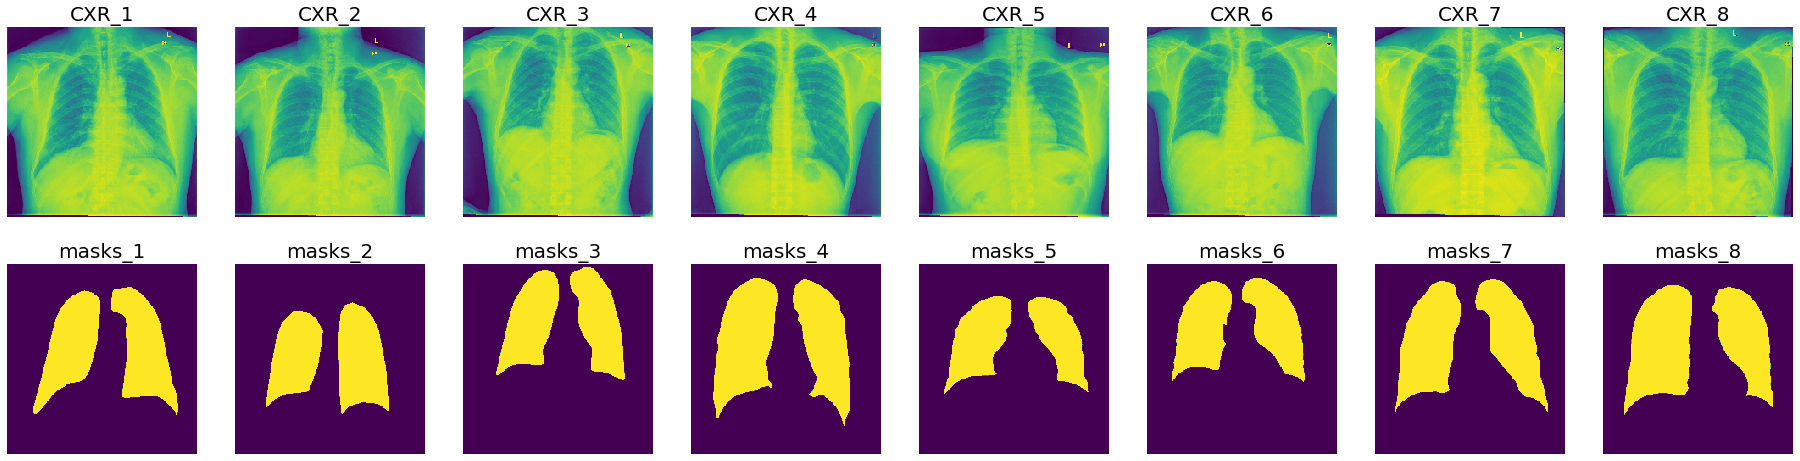

In [ ]:
## VISUALIZACIÓN DE LOS PRIMEROS 8 inputs/targets
## =============================================================================

images = [input_img_paths, target_img_paths]
images_paths = ['dataset/CXR/', 'dataset/masks/']

n_rows = 2
n_cols = 8
plt.figure(figsize=(n_cols * 4, n_rows*4))
for row in range(n_rows):
    data = images[row]
    for col in range(n_cols):
        index = n_cols * row + col
        index_img = col
        plt.subplot(n_rows, n_cols, index + 1)
        img = cv2.imread(data[index_img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img, interpolation="nearest")
        plt.axis('off')
        title = data[index_img].split('/')
        plt.title(title[1] + '_' +  str(col+1), fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show();

In [ ]:
## CARGADOR DE IMÁGENES
## Itera sobre los datos como arrays Numpy y devuelve una tupla (input, target) para cada batch
## ===========================================================================================

class OxforCXR(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x/255., y/255.

In [ ]:
## DIVISIÓN DEL DATASET: train/test en la proporción 80/20
## =============================================================================

import random

# Mezcla aleatoria de los dataset input/target
val_samples = round(len(input_img_paths)*0.2)
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)

# Dataset de entrenamiento: 'train'
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

# Dataset de prueba: 'test'
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [ ]:
## TAMAÑO DE CADA DIVISIÓN
## =============================================================================

print(f' Tamaño del dataset de entrenamiento para inputs  {len(train_input_img_paths)}')
print(f' Tamaño del dataset de entrenamiento para targets {len(train_target_img_paths)}')
print(f' Tamaño del dataset de prueba para inputs  {len(val_input_img_paths)}')
print(f' Tamaño del dataset de prueba para targets {len(val_target_img_paths)}')

 Tamaño del dataset de entrenamiento para inputs  563
 Tamaño del dataset de entrenamiento para targets 563
 Tamaño del dataset de prueba para inputs  141
 Tamaño del dataset de prueba para targets 141


In [ ]:
## CREACIÓN DE LOS GENERADORES DE IMÁGENES
## =============================================================================

train_gen = OxforCXR(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxforCXR(batch_size, img_size, val_input_img_paths, val_target_img_paths)

##2. Creación y entrenamiento del modelo

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA
## =============================================================================

from functools import partial

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1)

DefaultConv2DTraspose = partial(Conv2DTranspose,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=2)


def build_model(input_layer, start_neurons):

    # Rama izquierda
    conv1 = DefaultConv2D(filters=start_neurons*1)(input_layer)
    conv1 = DefaultConv2D(filters=start_neurons*1)(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = DefaultConv2D(filters=start_neurons*2)(pool1)
    conv2 = DefaultConv2D(filters=start_neurons*2)(conv2)
    pool2 = MaxPooling2D(pool_size=2)(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = DefaultConv2D(filters=start_neurons*4)(pool2)
    conv3 = DefaultConv2D(filters=start_neurons*4)(conv3)
    pool3 = MaxPooling2D(pool_size=2)(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = DefaultConv2D(filters=start_neurons*8)(pool3)
    conv4 = DefaultConv2D(filters=start_neurons*8)(conv4)
    pool4 = MaxPooling2D(pool_size=2)(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Fondo
    convm = DefaultConv2D(filters=start_neurons*16)(pool4)
    convm = DefaultConv2D(filters=start_neurons*16)(convm)
    
    # Rama derecha
    deconv4 = DefaultConv2DTraspose(filters=start_neurons*8)(convm)
    uconv4  = concatenate([deconv4, conv4])
    uconv4  = Dropout(0.5)(uconv4)
    uconv4  = DefaultConv2D(filters=start_neurons*8)(uconv4)
    uconv4  = DefaultConv2D(filters=start_neurons*8)(uconv4)

    deconv3 = DefaultConv2DTraspose(filters=start_neurons*4)(uconv4)
    uconv3  = concatenate([deconv3, conv3])
    uconv3  = Dropout(0.5)(uconv3)
    uconv3  = DefaultConv2D(filters=start_neurons*4)(uconv3)
    uconv3  = DefaultConv2D(filters=start_neurons*4)(uconv3)

    deconv2 = DefaultConv2DTraspose(filters=start_neurons*2)(uconv3)
    uconv2  = concatenate([deconv2, conv2])
    uconv2  = Dropout(0.5)(uconv2)
    uconv2  = DefaultConv2D(filters=start_neurons*2)(uconv2)
    uconv2  = DefaultConv2D(filters=start_neurons*2)(uconv2)

    deconv1 = DefaultConv2DTraspose(filters=start_neurons*1)(uconv2)
    uconv1  = concatenate([deconv1, conv1])
    uconv1  = Dropout(0.5)(uconv1)
    uconv1  = DefaultConv2D(filters=start_neurons*1)(uconv1)
    uconv1  = DefaultConv2D(filters=start_neurons*1)(uconv1)
    
    output_layer = Conv2D(1, 1, padding='same', activation='sigmoid')(uconv1)
    
    return output_layer

input_layer = Input((224, 224, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 224, 224, 16) 448         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 224, 224, 16) 2320        conv2d_93[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 112, 112, 16) 0           conv2d_94[0][0]                  
____________________________________________________________________________________________

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(optimizer='adam', 
              loss= 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'segmentation.h5')

history = model.fit(
                  train_gen,
                  epochs=60,
                  validation_data= val_gen,
                  callbacks=[checkpoint_cb])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'segmentation.npy', history.history)

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'segmentation.h5')
history = np.load(base_dir + 'segmentation.npy', allow_pickle='TRUE').item()

##3. Análisis de resultados

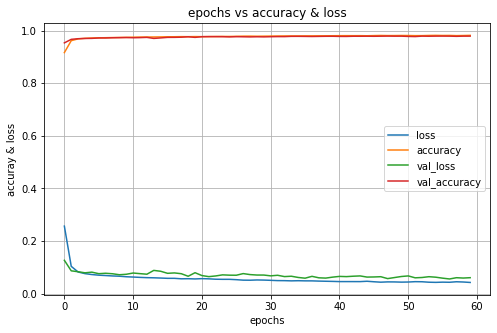

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_gen)
result_test = model.evaluate(val_gen)

4/4 [==============================] - 1s 171ms/step - loss: 0.0602 - accuracy: 0.9794


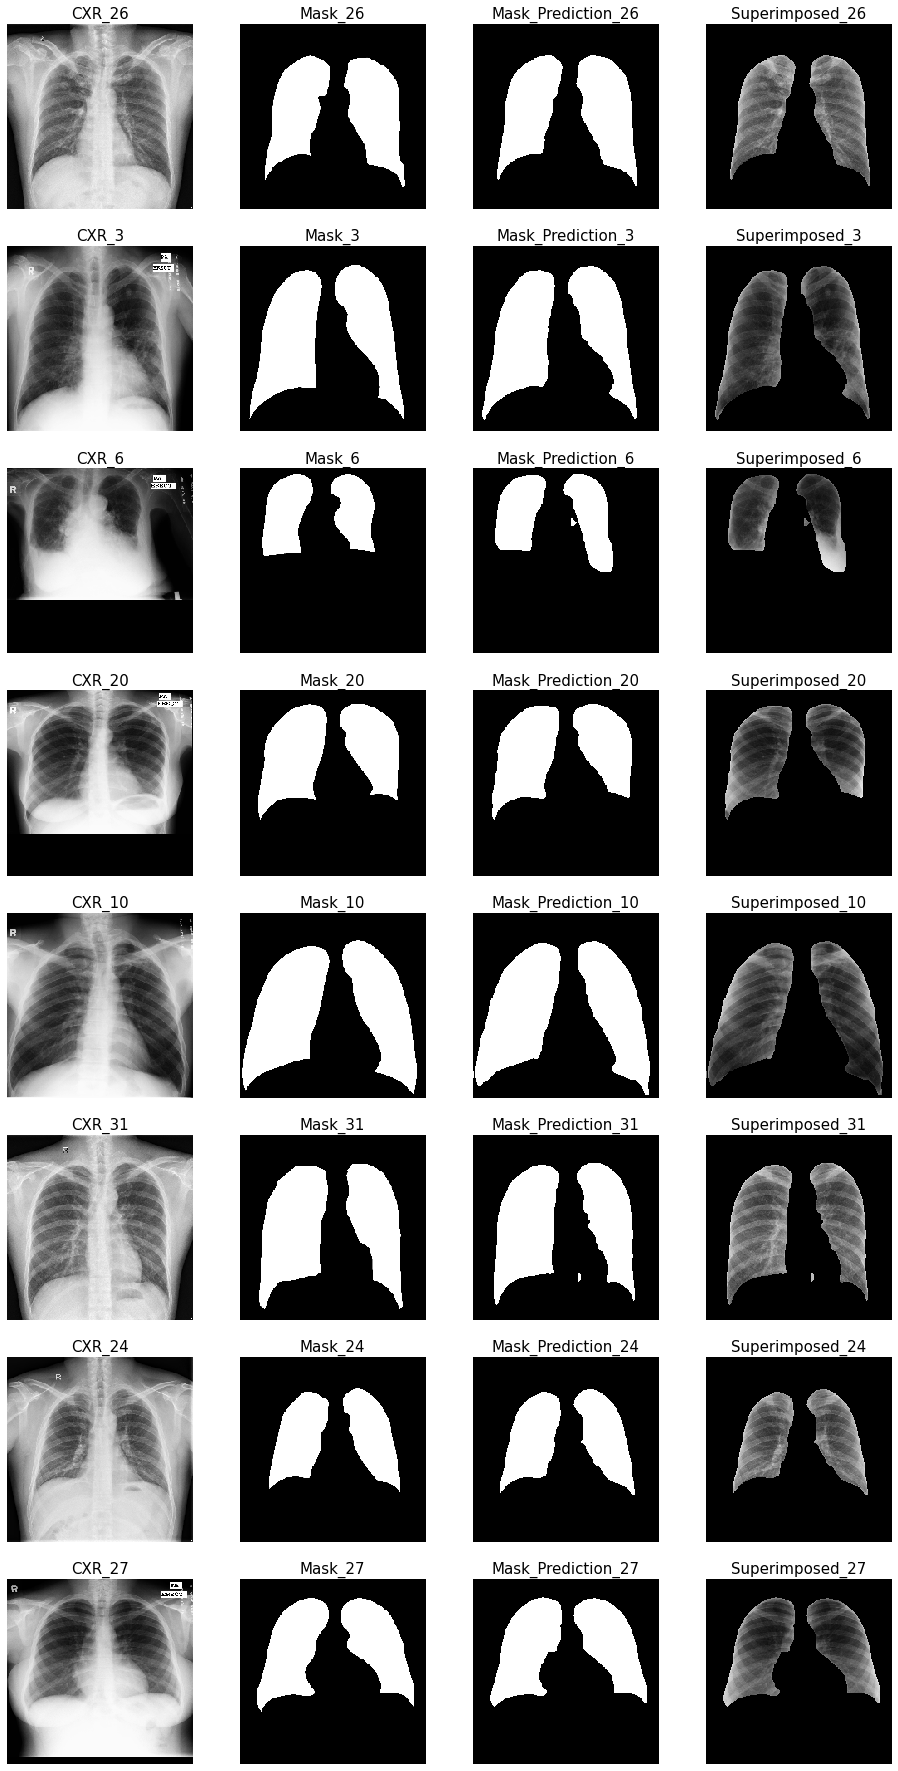

In [ ]:
## VISUALIZACIÓN ALEATORIA DE 8 PREDICCIONES
## =============================================================================

import random

n_rows = 8
n_cols = 4

plt.figure(figsize=(n_cols * 4, n_rows*4))
for row in range(n_rows):
      
  image = random.randrange(32)

  # Imagen original
  plt.subplot(n_rows, n_cols, n_cols * row + 1)
  img_original = np.expand_dims(val_gen[0][0][image], axis=0)
  plt.imshow(img_original[0,:,:,:], interpolation="nearest")
  plt.title('CXR_'+ str(image) , fontsize=15)
  plt.axis('off')

  # Máscara
  plt.subplot(n_rows, n_cols, n_cols * row + 2)
  img_mask = val_gen[0][1][image]
  img_mask = np.dstack([img_mask, img_mask, img_mask])
  plt.imshow(img_mask, interpolation="nearest")
  plt.title('Mask_'+ str(image) , fontsize=15)
  plt.axis('off')

  # Predicción de la máscara
  plt.subplot(n_rows, n_cols, n_cols * row + 3)
  pred = model.predict(img_original)
  pred = np.dstack([pred[0], pred[0], pred[0]])
  plt.imshow(pred.round(), interpolation="nearest")
  plt.title('Mask_Prediction_' + str(image) , fontsize=15)
  plt.axis('off')

  # Superposición de original & predicción
  plt.subplot(n_rows, n_cols, n_cols * row + 4)
  seg = img_original[0,:,:,:]*pred.round()
  plt.imshow(seg, interpolation="nearest")
  plt.title('Superimposed_' + str(image) , fontsize=15)
  plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('prediction.png')
plt.show();

##4. Implementación del dataset original

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## DIRECTORIOS NECESARIOS
## =============================================================================

train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
COVID_train = list(map(lambda image: os.path.join(train_dir + 'COVID', image), os.listdir(os.path.join(train_dir + 'COVID'))))
COVID_test =  list(map(lambda image: os.path.join(test_dir  + 'COVID', image), os.listdir(os.path.join(test_dir  + 'COVID'))))

Lung_Opacity_train = list(map(lambda image: os.path.join(train_dir + 'Lung_Opacity', image), os.listdir(os.path.join(train_dir + 'Lung_Opacity'))))
Lung_Opacity_test =  list(map(lambda image: os.path.join(test_dir  + 'Lung_Opacity', image), os.listdir(os.path.join(test_dir  + 'Lung_Opacity'))))

Normal_train = list(map(lambda image: os.path.join(train_dir + 'Normal', image), os.listdir(os.path.join(train_dir + 'Normal'))))
Normal_test =  list(map(lambda image: os.path.join(test_dir  + 'Normal', image), os.listdir(os.path.join(test_dir  + 'Normal'))))

Viral_Pneumonia_train = list(map(lambda image: os.path.join(train_dir + 'Viral_Pneumonia', image), os.listdir(os.path.join(train_dir + 'Viral_Pneumonia'))))
Viral_Pneumonia_test =  list(map(lambda image: os.path.join(test_dir  + 'Viral_Pneumonia', image), os.listdir(os.path.join(test_dir  + 'Viral_Pneumonia'))))

In [ ]:
## PREDICCIÓN DE MÁSCARAS
## =============================================================================

i = 0
for image in Normal_test:
  img = Image.open(image)
  img = np.asarray(img, dtype='float32')/255.
  img = np.dstack([img, img, img])
  img_exp = np.expand_dims(img, axis=0)
  img_pred = model.predict(img_exp)
  img_pred = np.dstack([img_pred[0], img_pred[0], img_pred[0]])
  seg = img*img_pred.round()
  plt.imsave('dataset_segmentation/test/Normal/' + str(i)+ '.png', seg, cmap='Greys')
  i = i+1

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = list(train_generator.class_indices.keys())
class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

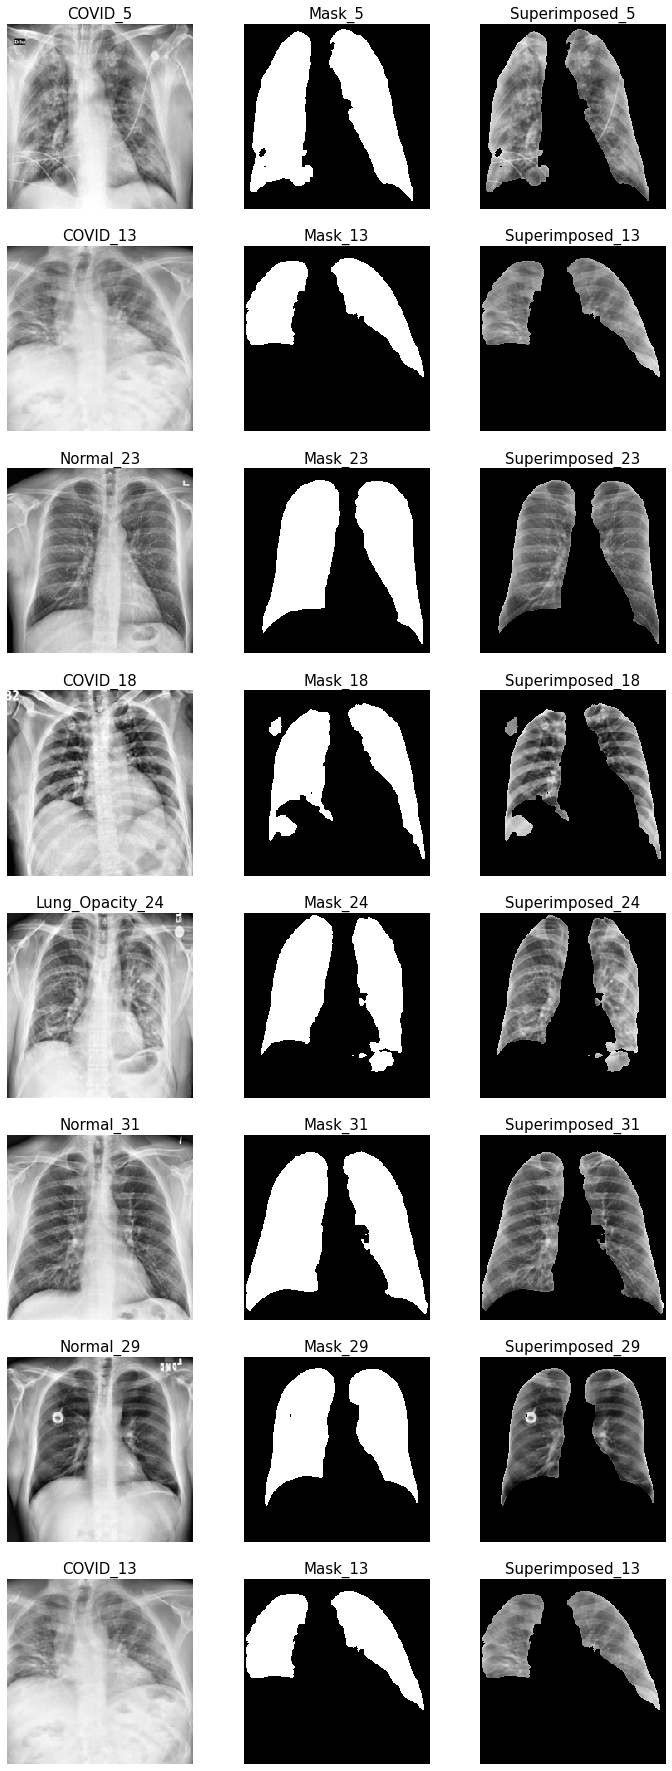

In [ ]:
## VISUALIZACIÓN ALEATORIA DE 8 inputs/targets
## =============================================================================

n_rows = 8
n_cols = 3

plt.figure(figsize=(n_cols * 4, n_rows*4))
for row in range(n_rows):
      
      image = random.randrange(32)
      
      # Imagen original
      plt.subplot(n_rows, n_cols, n_cols * row + 1)
      img_original = np.expand_dims(train_generator[0][0][image], axis=0)
      plt.imshow(img_original[0,:,:,:], interpolation="nearest")
      category = np.argmax(train_generator[0][1][image])
      plt.title(class_names[category] + '_' + str(image) , fontsize=15)
      plt.axis('off')

      # Predicción
      plt.subplot(n_rows, n_cols, n_cols * row + 2)
      pred = model.predict(img_original)
      pred = np.dstack([pred[0], pred[0], pred[0]])
      plt.imshow(pred.round(), interpolation="nearest")
      plt.title('Mask_' + str(image) , fontsize=15)
      plt.axis('off')

      # Superposición de original & predicción
      plt.subplot(n_rows, n_cols, n_cols * row + 3)
      seg = img_original[0,:,:,:]*pred.round()
      plt.imshow(seg, interpolation="nearest")
      plt.title('Superimposed_' + str(image) , fontsize=15)
      plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('prediction_dataset_original.png')
plt.show();